# Advanced usage of recurrent neural networks

In [1]:
from tensorflow import keras

## A temperature forecasting problem

```
wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
unzip jena_climate_2009_2016.csv.zip
```

In [3]:
import os

data_dir = '/Users/momo/Documents/keras_datasets'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


共有420 551 行数据（每行是一个时间步，记录了一个日期和14 个与天气有关的值），还输出了表头

In [4]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [5]:
float_data[:10]

array([[ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
         9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
         1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
         1.75000e+00,  1.52300e+02],
       [ 9.96570e+02, -8.41000e+00,  2.65010e+02, -9.28000e+00,
         9.34000e+01,  3.23000e+00,  3.02000e+00,  2.10000e-01,
         1.89000e+00,  3.03000e+00,  1.30980e+03,  7.20000e-01,
         1.50000e+00,  1.36100e+02],
       [ 9.96530e+02, -8.51000e+00,  2.64910e+02, -9.31000e+00,
         9.39000e+01,  3.21000e+00,  3.01000e+00,  2.00000e-01,
         1.88000e+00,  3.02000e+00,  1.31024e+03,  1.90000e-01,
         6.30000e-01,  1.71600e+02],
       [ 9.96510e+02, -8.31000e+00,  2.65120e+02, -9.07000e+00,
         9.42000e+01,  3.26000e+00,  3.07000e+00,  1.90000e-01,
         1.92000e+00,  3.08000e+00,  1.30919e+03,  3.40000e-01,
         5.00000e-01,  1.98000e+02],
       [ 9.96510e+02, -8.27000e+00,  2.65150e+02, -9.04000e+00,
         9.41000e+01

In [8]:
lines[:10]

['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30',
 '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10',
 '01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60',
 '01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00',
 '01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30',
 '01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70',
 '01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.80,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.50',
 '01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.40,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.60',
 '01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.80,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.50',
 '01.01.2009 01:40:00,996.53,-8.43,264.99,-9.3

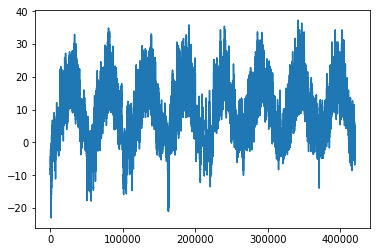

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

前10 天温度数据的图像。因为每10 分钟记录一个数据，所以每天有144 个数据点

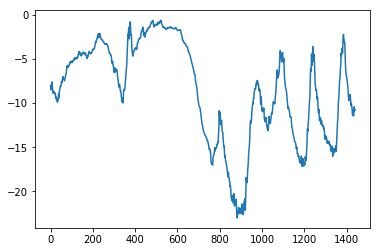

In [11]:
plt.plot(range(1440), temp[:1440])
plt.show()

在这张图中，你可以看到每天的周期性变化，尤其是最后4 天特别明显。另外请注意，这10 天一定是来自于很冷的冬季月份

## Preparing the data

一个时间步是10 分钟，每steps 个时间步采样一次数据，给定过去lookback 个时间步之内的数据，能否预测delay 个时间步之后的温度？用到的参数值如下。
- lookback = 720：给定过去5 天内的观测数据。
- steps = 6：观测数据的采样频率是每小时一个数据点。
- delay = 144：目标是未来 24 小时之后的数据

预处理数据的方法是，将每个时间序列减去其平均值，然后除以其标准差。我们将使用前200 000 个时间步作为训练数据，所以只对这部分数据计算平均值和标准差

In [12]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

下面是一个生成器。它生成了一个元组(samples, targets)，其中samples 是输入数据的一个批量，targets 是对应的目标温度数组。生成器的参数如下。
- data：浮点数数据组成的原始数组，将其标准化。
- lookback：输入数据应该包括过去多少个时间步。
- delay：目标应该在未来多少个时间步之后。
- min_index 和 max_index：data 数组中的索引，用于界定需要抽取哪些时间步。这有助于保存一部分数据用于验证、另一部分用于测试。
- shuffle：是打乱样本，还是按顺序抽取样本。
- batch_size：每个批量的样本数。
- step：数据采样的周期（单位：时间步）。我们将其设为6，为的是每小时抽取一个数据点。

In [14]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [15]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## A common sense, non-machine learning baseline

本例中，我们可以放心地假设，温度时间序列是连续的（明天的温度很可能接近今天的温度），并且具有每天的周期性变化。因此，一种基于常识的方法就是始终预测24 小时后的温度等于现在的温度。我们使用平均绝对误差（MAE）指标来评估这种方法。

In [18]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


得到的MAE 为0.29。因为温度数据被标准化成均值为0、标准差为1，所以无法直接对这个值进行解释。它转化成温度的平均绝对误差为0.29×temperature_std 摄氏度，即2.57℃。

In [19]:
celsius_mae = 0.29 * std[1]

In [20]:
celsius_mae

2.5672247338393395

## A basic machine learning approach

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 18s 36ms/step - loss: 1.0305 - val_loss: 0.4840
Epoch 2/20
500/500 [==============================] - 18s 35ms/step - loss: 0.3797 - val_loss: 0.4287
Epoch 3/20
500/500 [==============================] - 18s 35ms/step - loss: 0.2887 - val_loss: 0.3063
Epoch 4/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2637 - val_loss: 0.3056
Epoch 5/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2510 - val_loss: 0.3059
Epoch 6/20
500/500 [==============================] - 18s 35ms/step - loss: 0.2410 - val_loss: 0.3164
Epoch 7/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2358 - val_loss: 0.3189
Epoch 8/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2305 - val_loss: 0.3410
Epoch 9/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2242 - val_loss: 0.3289
Epoch 10/20
500/500 [==============================] - 17s 35ms/step - loss: 0.220

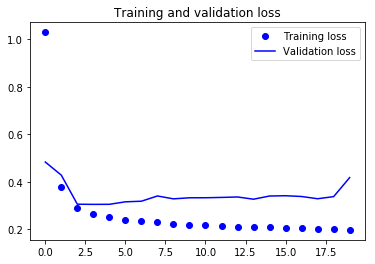

In [22]:
import matplotlib.pyplot as plt

%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## A first recurrent baseline

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 455s 910ms/step - loss: 0.3030 - val_loss: 0.2735
Epoch 2/20
500/500 [==============================] - 429s 857ms/step - loss: 0.2842 - val_loss: 0.2668
Epoch 3/20
500/500 [==============================] - 426s 853ms/step - loss: 0.2790 - val_loss: 0.2669
Epoch 4/20
500/500 [==============================] - 424s 848ms/step - loss: 0.2745 - val_loss: 0.2654
Epoch 5/20
500/500 [==============================] - 426s 852ms/step - loss: 0.2690 - val_loss: 0.2652
Epoch 6/20
500/500 [==============================] - 433s 867ms/step - loss: 0.2650 - val_loss: 0.2702
Epoch 7/20
500/500 [==============================] - 437s 875ms/step - loss: 0.2601 - val_loss: 0.2708
Epoch 8/20
500/500 [==============================] - 427s 854ms/step - loss: 0.2541 - val_loss: 0.2733
Epoch 9/20
500/500 [==============================] - 448s 896ms/step - loss: 0.2478 - val_loss: 0.2758
Epoch 10/20
500/500 [==============================] - 425s 850m

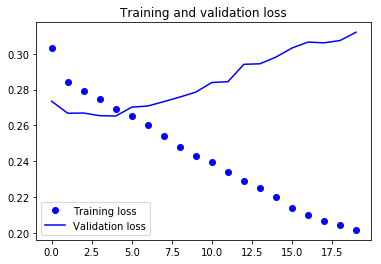

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Using recurrent dropout to fight overfitting

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Stacking recurrent layers

模型不再过拟合，但似乎遇到了性能瓶颈，所以我们应该考虑增加网络容量。回想一下机器学习的通用工作流程：增加网络容量通常是一个好主意，直到过拟合变成主要的障碍（假设你已经采取基本步骤来降低过拟合，比如使用dropout）。只要过拟合不是太严重，那么很可能是容量不足的问题。增加网络容量的通常做法是增加每层单元数或增加层数。循环层堆叠（recurrent layerstacking）是构建更加强大的循环网络的经典方法。

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

结果如图所示。可以看到，添加一层的确对结果有所改进，但并不显著。我们可以得出两个结论。
- 因为过拟合仍然不是很严重，所以可以放心地增大每层的大小，以进一步改进验证损失。但这么做的计算成本很高。
- 添加一层后模型并没有显著改进，所以你可能发现，提高网络能力的回报在逐渐减小。

## Using bidirectional RNNs

In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)